The logic of **gradient boosting** is very simple (if explained intuitively, without using mathematical notation). I expect that whoever is reading this would have done simple linear regression modeling.
One of the very basic assumption of linear regression is that it's sum of residuals is 0. Although, tree based models are not based on any of such assumptions, but if we think logic (not statistics) behind these assumptions, we might argue that, if sum of residuals is not 0, then most probably there is some pattern in the residuals of our model which can be leveraged to make our model better.
So, the intuition behind gradient boosting algorithm is to `leverage the pattern in residuals and strenghten a weak prediction model, until our residuals become randomly (maybe random normal too) distributed`. Once we reach a stage that residuals do not have any pattern that could be modeled, we can stop modeling residuals (otherwise it might lead to overfitting). Algorithmically, we are minimizing our loss function, such that test loss reach it’s minima.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn import metrics
import math

In [2]:
class DecisionTree():
    def __init__(self, x, y, idxs = None, min_leaf=2):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

## Data simulation

In [3]:
x = np.arange(0,50)
x = pd.DataFrame({'x':x})

In [4]:
# just random uniform distributions in differnt range

y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4,y5))
y = y[:,None]

## Gradient Boosting: 
Gradient Boosting is a powerful ensemble learning algorithm that iteratively improves a weak predictive model by focusing on patterns in the residuals. This section explains the core idea of gradient boosting, its mathematical intuition, and implements it from scratch using decision trees.

### Key Concepts:
1. **Residual Patterns**: If residuals are not random, they indicate patterns that can be modeled further.
2. **Weak Learners**: Decision trees are used as weak learners, sequentially minimizing the loss function.
3. **Stopping Criteria**: The process halts when the residuals become random or start overfitting.


## Scatter plot of data

In [5]:
x.shape, y.shape

((50, 1), (50, 1))

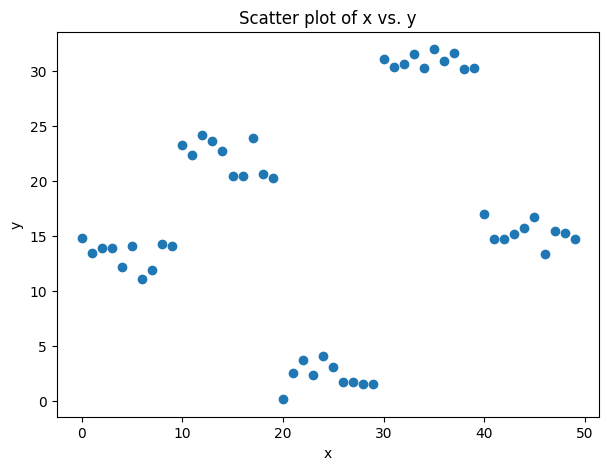

In [6]:
plt.figure(figsize=(7,5))
plt.plot(x,y, 'o')
plt.title("Scatter plot of x vs. y")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [7]:
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

### Observing Residuals and Predictions

The iterative process adjusts predictions by learning patterns from residuals. Below is the visualization of predictions and residuals at each iteration:
- **Left Plot**: The updated predictions for `y`.
- **Right Plot**: Residuals as the process progresses. Randomly distributed residuals indicate a good fit.


/tmp/ipykernel_30366/240426486.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)
/tmp/ipykernel_30366/53786931.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13,2.5))


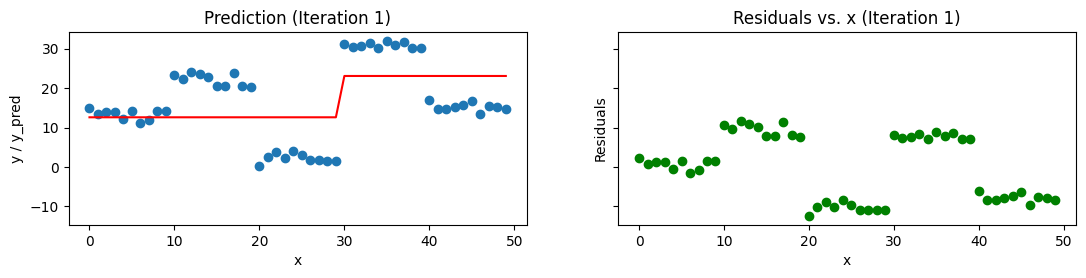

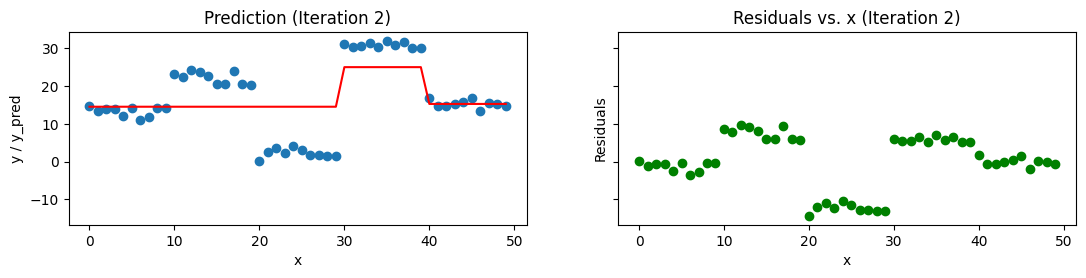

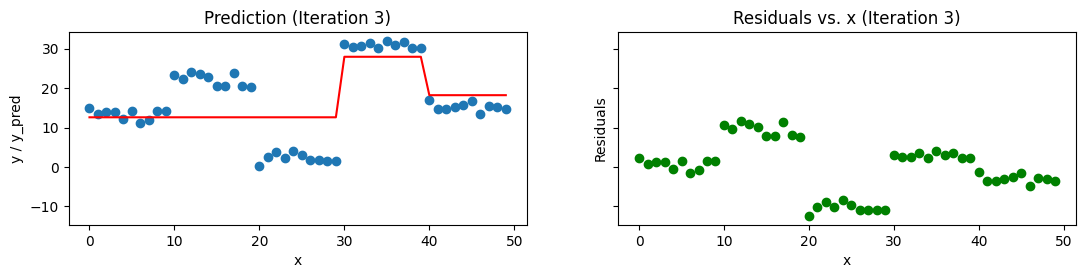

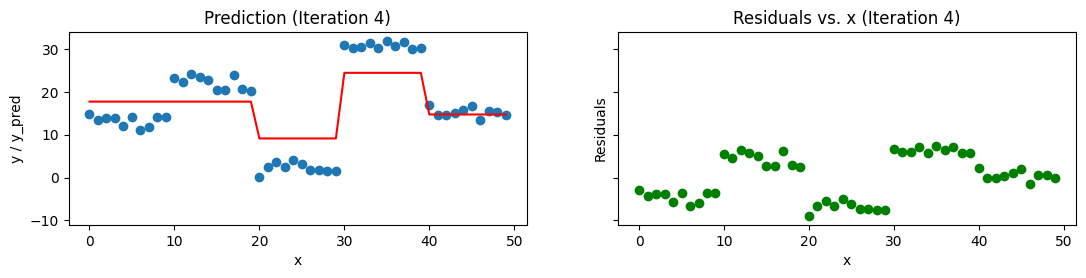

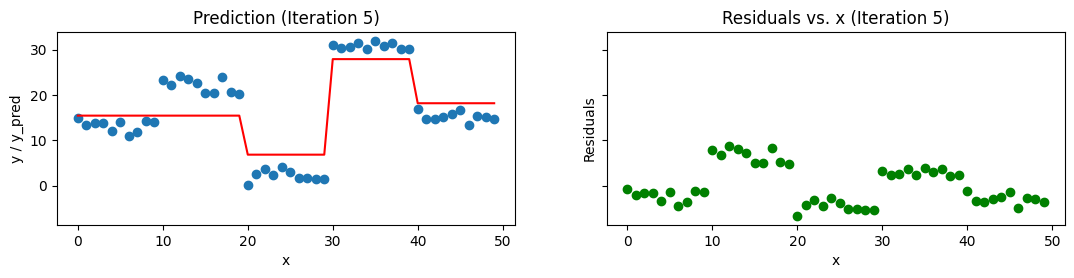

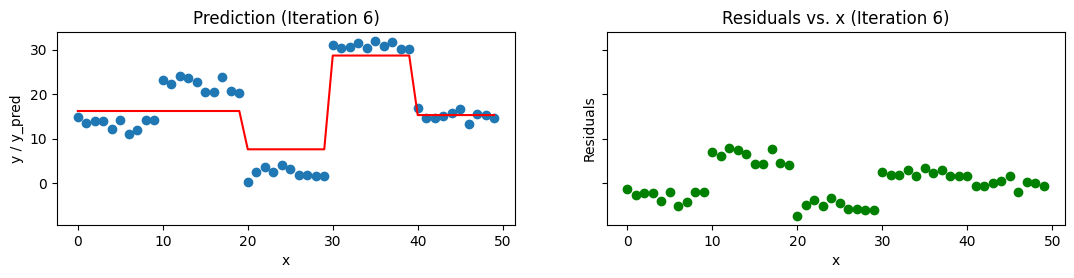

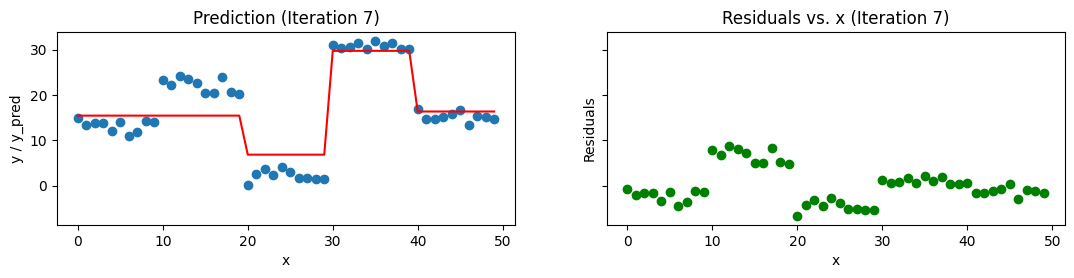

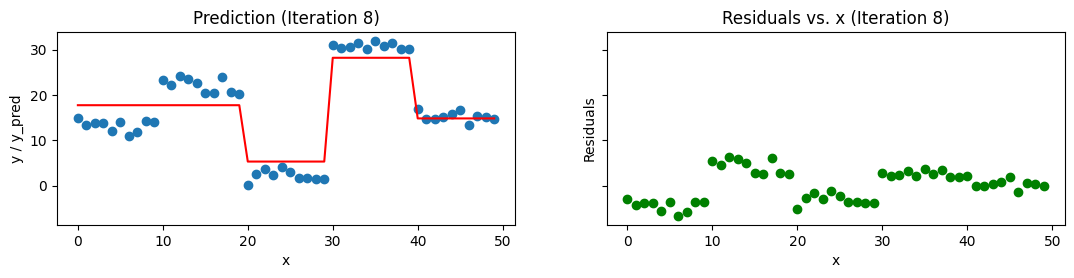

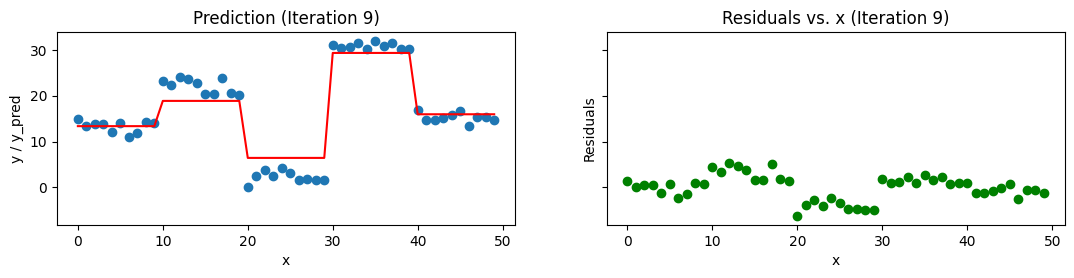

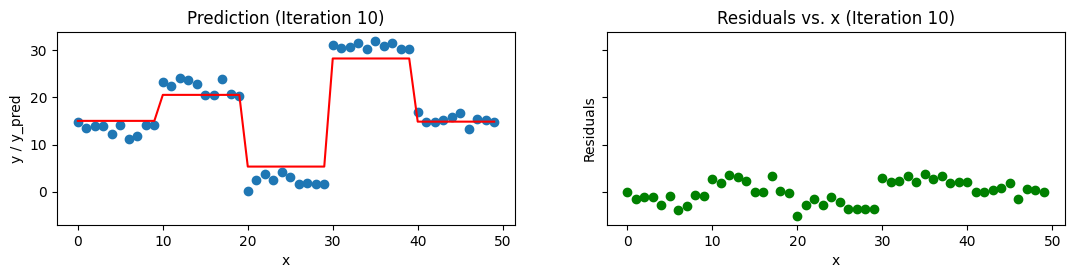

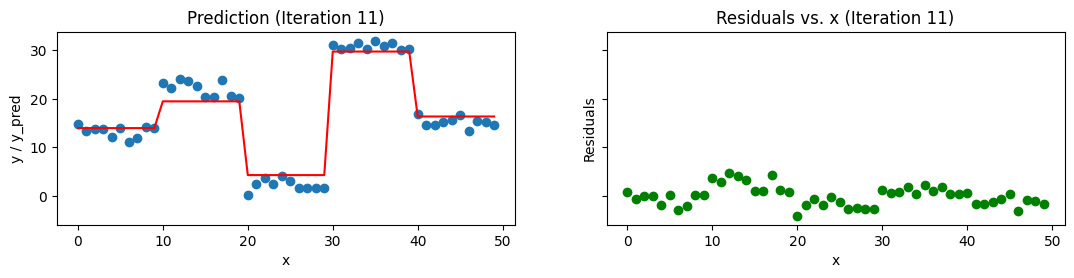

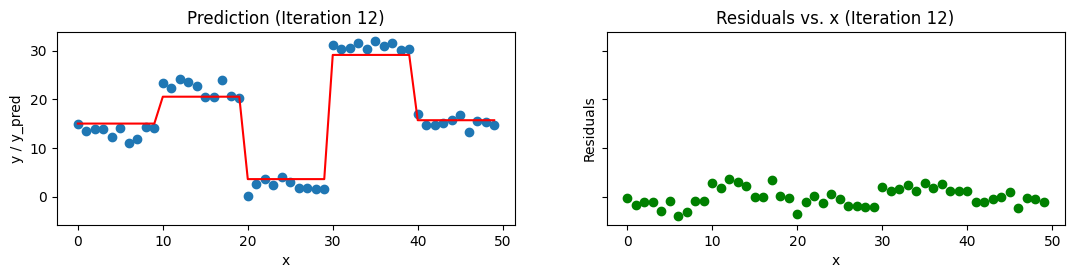

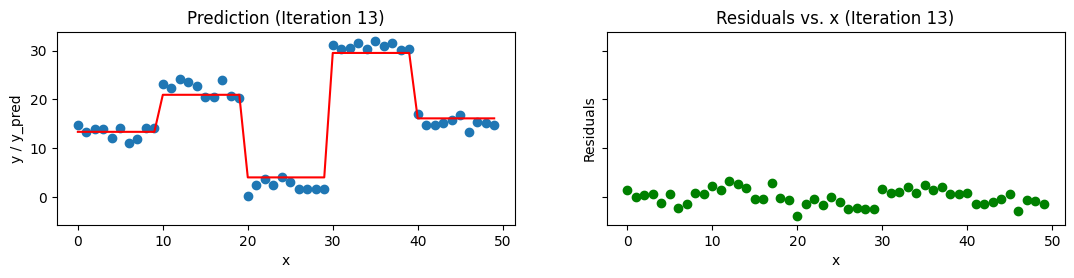

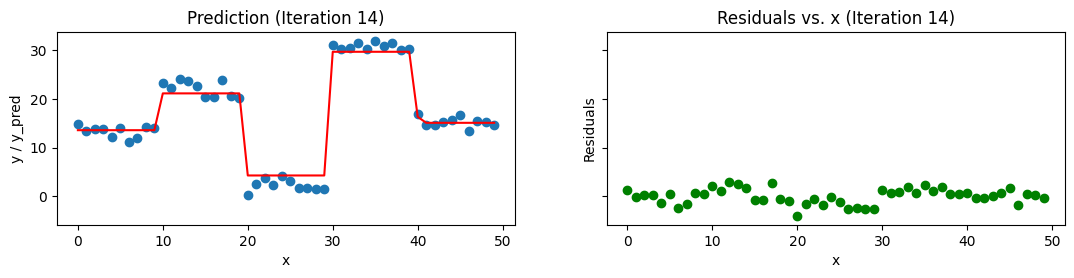

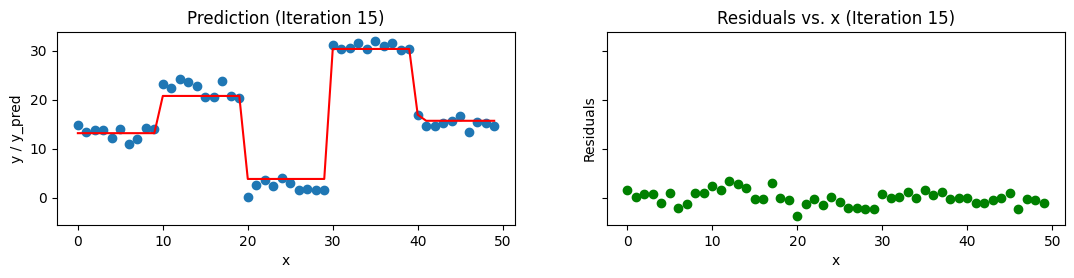

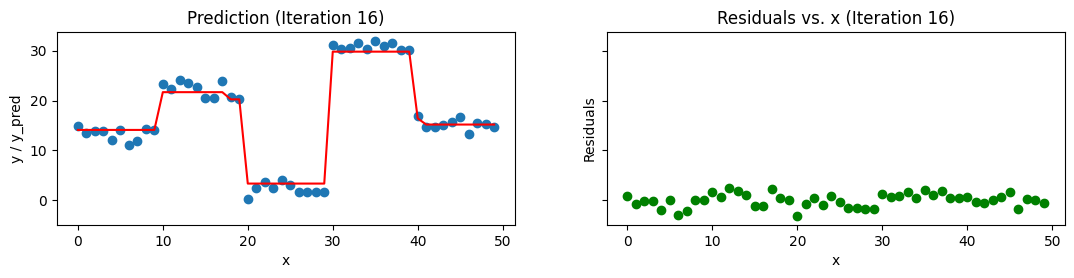

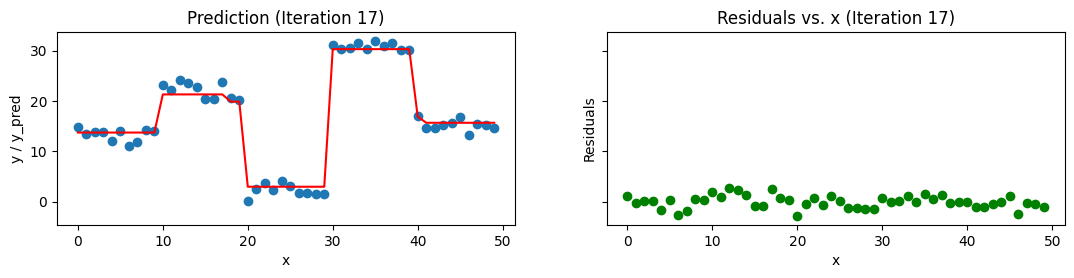

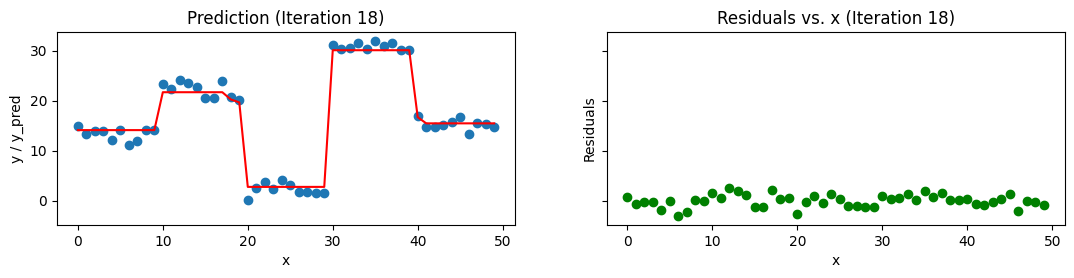

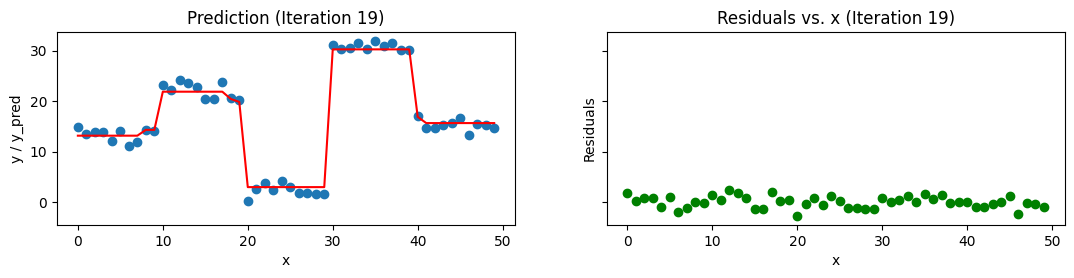

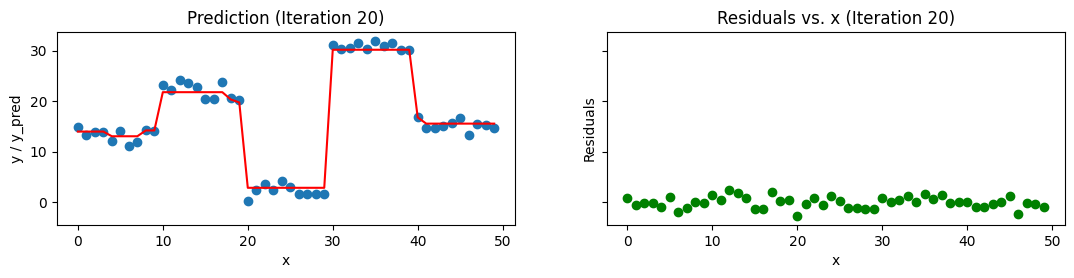

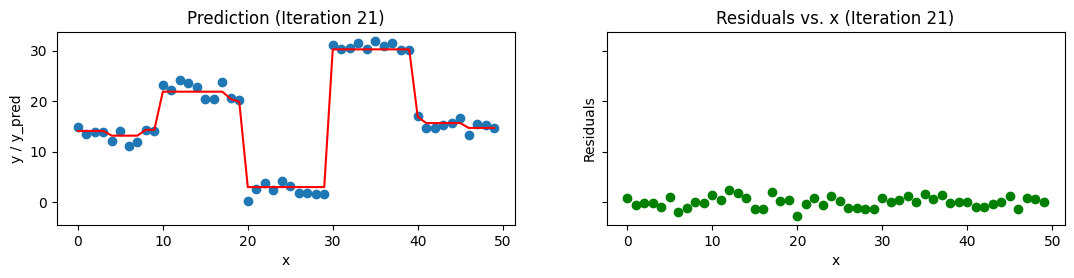

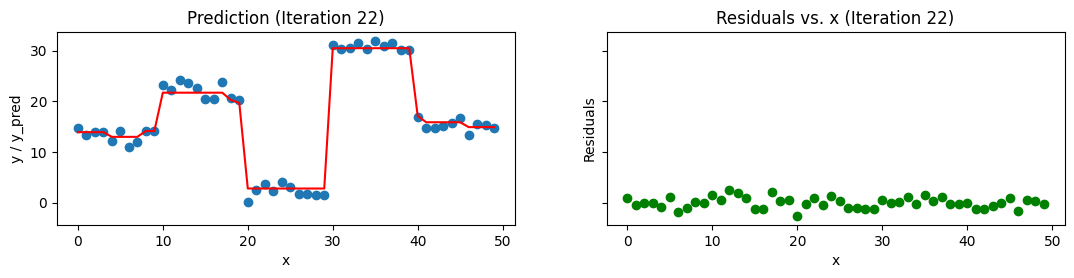

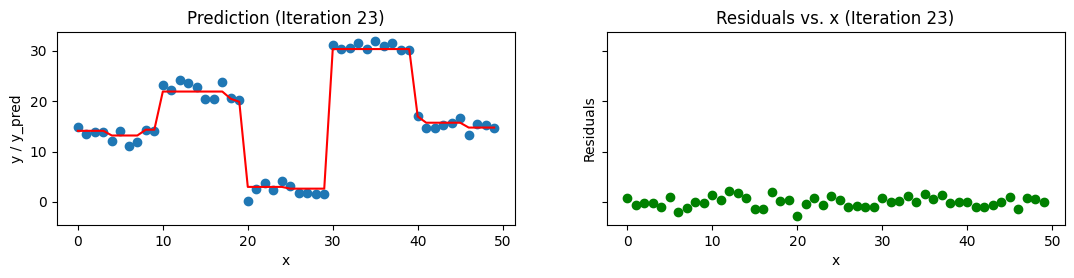

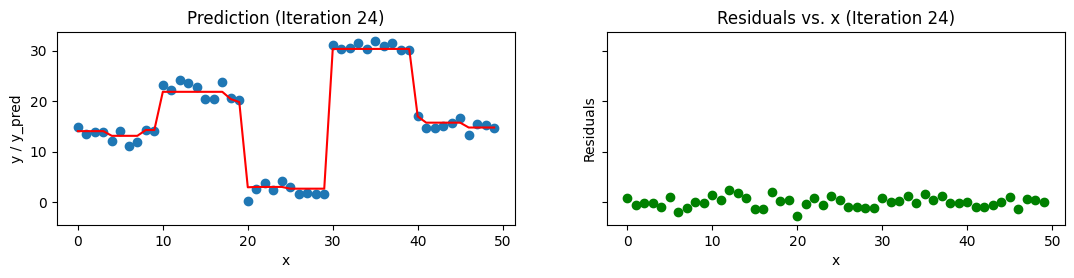

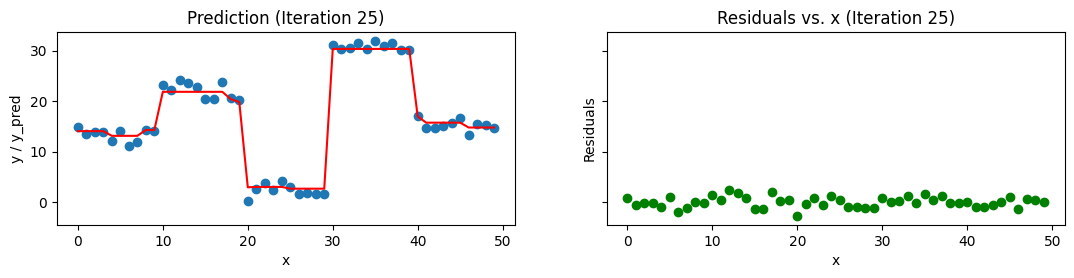

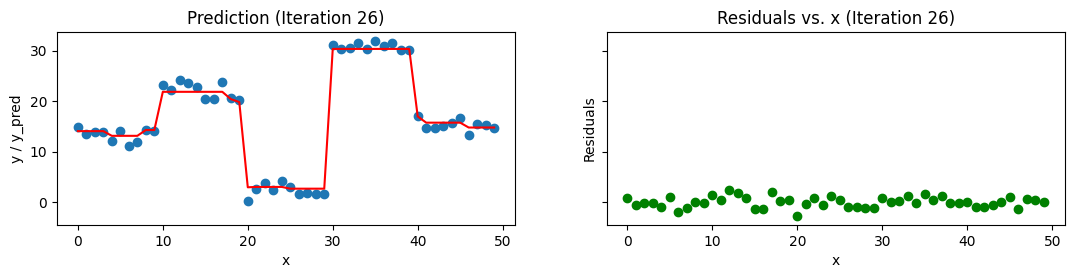

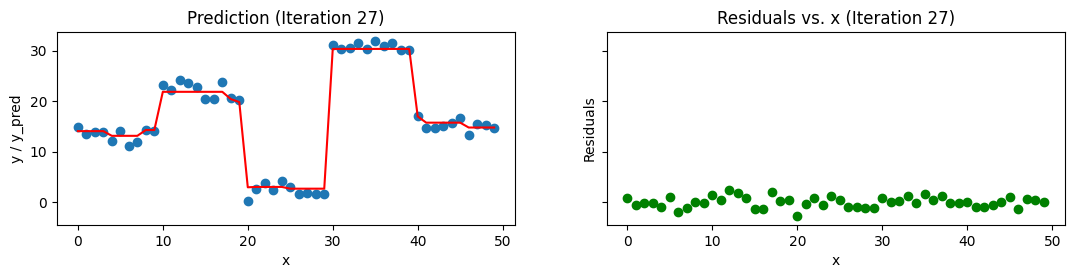

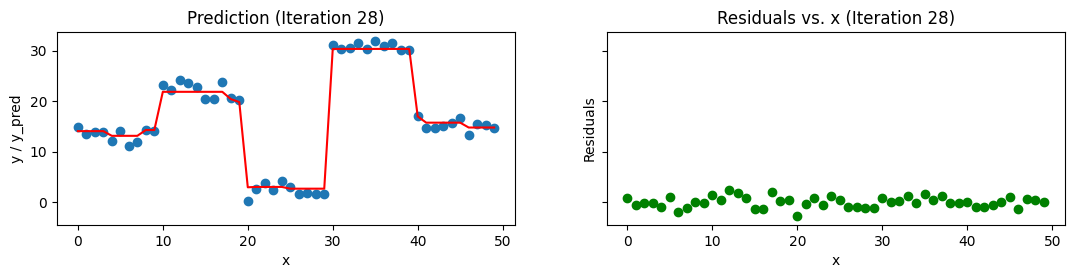

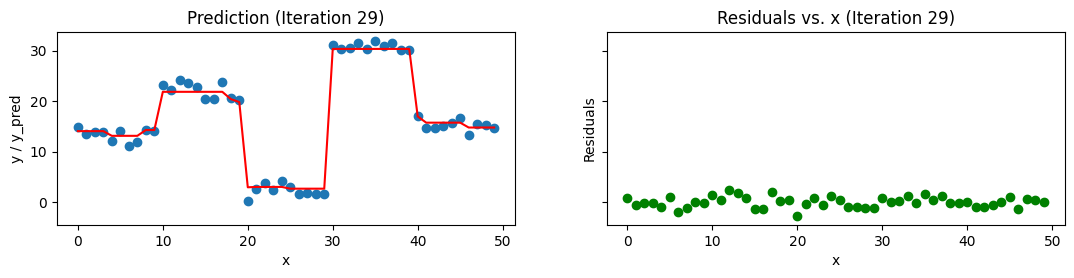

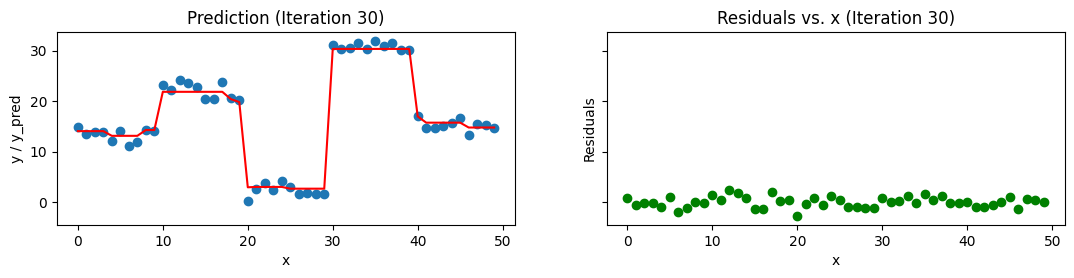

In [8]:
xi = x # initialization of input
yi = y # initialization of target
# x,y --> use where no need to change original y
ei = 0 # initialization of error
n = len(yi)  # number of rows
predf = 0 # initial prediction 0

for i in range(30): # like n_estimators
    tree = DecisionTree(xi,yi)
    tree.find_better_split(0)
    
    r = np.where(xi == tree.split)[0][0]    
    
    left_idx = np.where(xi <= tree.split)[0]
    right_idx = np.where(xi > tree.split)[0]
    
    predi = np.zeros(n)
    np.put(predi, left_idx, np.repeat(np.mean(yi[left_idx]), r))  # replace left side mean y
    np.put(predi, right_idx, np.repeat(np.mean(yi[right_idx]), n-r))  # right side mean y
    
    predi = predi[:,None]  # make long vector (nx1) in compatible with y
    predf = predf + predi  # final prediction will be previous prediction value + new prediction of residual
    
    ei = y - predf  # needed originl y here as residual always from original y    
    yi = ei # update yi as residual to reloop
    
    
    # plotting after prediction
    xa = np.array(x.x) # column name of x is x 
    order = np.argsort(xa)
    xs = np.array(xa)[order]
    ys = np.array(predf)[order]
    
    #epreds = np.array(epred[:,None])[order]

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13,2.5))

    ax1.plot(x,y, 'o')
    ax1.plot(xs, ys, 'r')
    ax1.set_title(f'Prediction (Iteration {i+1})')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y / y_pred')

    ax2.plot(x, ei, 'go')
    ax2.set_title(f'Residuals vs. x (Iteration {i+1})')
    ax2.set_xlabel('x')
    ax2.set_ylabel('Residuals')
    
    

Errors are not changing much after `20th iteration` and pattern in residuals is also removed. Residuals look distributed around the mean

### Maths behind this logic

$ Predictions = y_i^p $  
$ Loss = L(y_i, y_i^p) $  
$ Loss = MSE = \sum {(y_i - y_i^p)}^2 $  
$ y_i^p = y_i^p + \alpha * \delta {L(y_i, y_i^p)}/ \delta{y_i^p } $  
$ y_i^p = y_i^p + \alpha * \delta {\sum {(y_i - y_i^p)}^2}/ \delta{y_i^p } $  
$ y_i^p = y_i^p - \alpha * 2*{\sum {(y_i - y_i^p)}} $  

where, $y_i$ = ith target value, $y_i^p$ = ith prediction, $ L(y_i, y_i^p) $ is Loss function, $\alpha$ is learning rate. So the last equation tells us that, we need to adjust predictions based on our residuals, i.e. $\sum {(y_i - y_i^p)}$. This is what we did, we adjusted our predictions using the fit on residuals. (accordingly adjusting value of $\alpha$

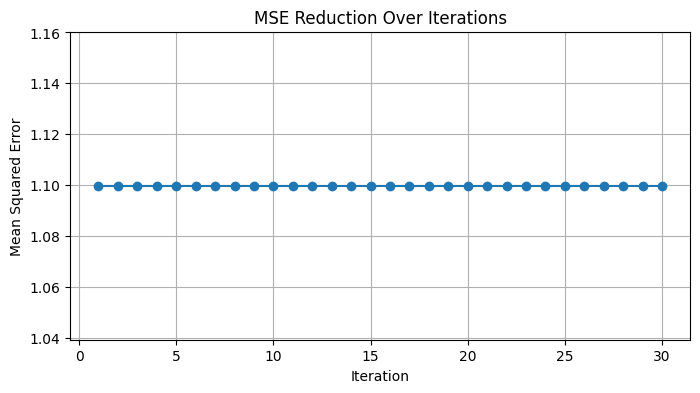

In [9]:
from sklearn.metrics import mean_squared_error

# Track errors over iterations
errors = []

for i in range(30):
    mse = mean_squared_error(y, predf)
    errors.append(mse)

# Plot the error reduction over iterations
plt.figure(figsize=(8, 4))
plt.plot(range(1, 31), errors, marker='o')
plt.title("MSE Reduction Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()


## XGBoost: Extreme Gradient Boosting

XGBoost is an optimized implementation of gradient boosting designed for speed and performance. It adds:
- **Regularization**: Helps prevent overfitting.
- **Parallel Processing**: Speeds up computation.
- **Tree Pruning**: Stops tree growth when further splitting adds no significant gain.

We will explore how to use XGBoost with a dataset and tune its hyperparameters for optimal performance.


XGBoost MSE: 0.23351799787958533


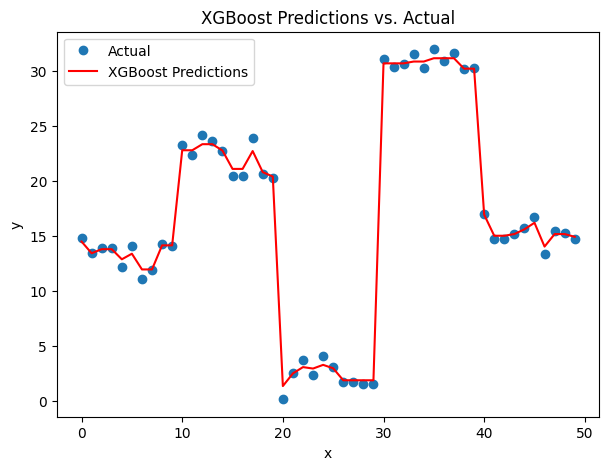

In [10]:
from xgboost import XGBRegressor

# Instantiate and train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
xgb_model.fit(x, y)

# Predictions and evaluation
xgb_pred = xgb_model.predict(x)
mse_xgb = mean_squared_error(y, xgb_pred)
print(f"XGBoost MSE: {mse_xgb}")

# Plot predictions vs actual
plt.figure(figsize=(7, 5))
plt.plot(x, y, 'o', label="Actual")
plt.plot(x, xgb_pred, 'r', label="XGBoost Predictions")
plt.title("XGBoost Predictions vs. Actual")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid_search_xgb = GridSearchCV(estimator=XGBRegressor(random_state=0), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_xgb.fit(x, y)

print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)


Best Parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50}


## LightGBM: Light Gradient Boosting Machine

LightGBM is another gradient boosting framework known for its efficiency on large datasets. Key features include:
- **Histogram-based Learning**: Speeds up training by binning continuous features.
- **Leaf-wise Tree Growth**: Focuses on reducing loss faster but might lead to overfitting on small datasets.

Let's implement LightGBM and compare its performance.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 1
[LightGBM] [Info] Start training from score 16.789872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/home/yahya/Innovayio/Courses/Data Science and Machine Learninng using Python Workshop/env/lib/python3.12/site-packages/lightgbm/basic.py:357: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


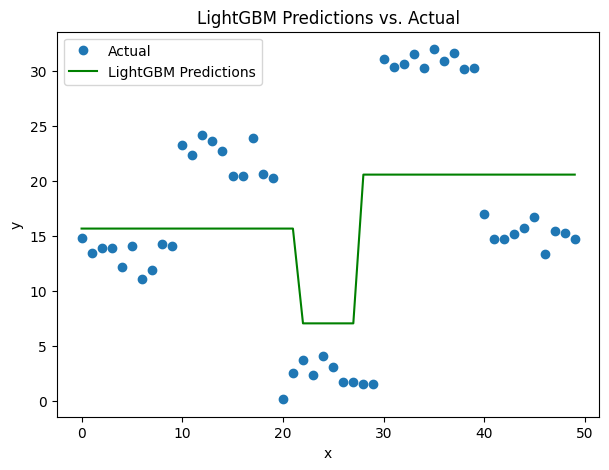

In [12]:
from lightgbm import LGBMRegressor

# Train LightGBM model
lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
lgbm_model.fit(x, y)

# Predictions and evaluation
lgbm_pred = lgbm_model.predict(x)
mse_lgbm = mean_squared_error(y, lgbm_pred)
print(f"LightGBM MSE: {mse_lgbm}")

# Plot predictions vs actual
plt.figure(figsize=(7, 5))
plt.plot(x, y, 'o', label="Actual")
plt.plot(x, lgbm_pred, 'g', label="LightGBM Predictions")
plt.title("LightGBM Predictions vs. Actual")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


## Comparison of Gradient Boosting Models

Below is a summary of Mean Squared Errors for each model:
1. **Gradient Boosting**: Implemented manually.
2. **XGBoost**: Optimized and fast gradient boosting.
3. **LightGBM**: Efficient and scalable boosting.

We summarize their performance and provide insights.


In [13]:
# Summarize performance
print(f"Manual Gradient Boosting MSE: {errors[-1]:.4f}")
print(f"XGBoost MSE: {mse_xgb:.4f}")
print(f"LightGBM MSE: {mse_lgbm:.4f}")


Manual Gradient Boosting MSE: 1.0998
XGBoost MSE: 0.2335
LightGBM MSE: 62.3347
